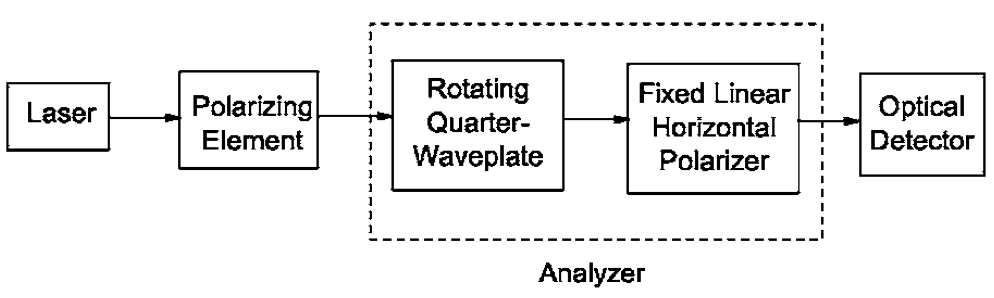

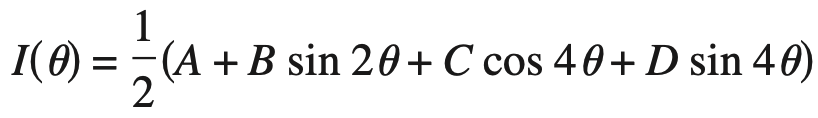

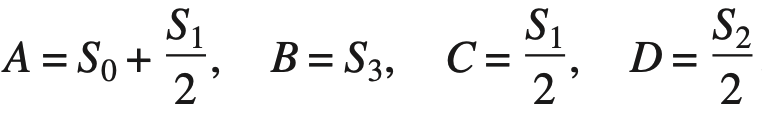

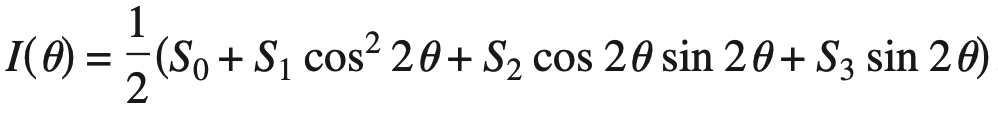

In [ ]:
import lmfit
import numpy as np


def intensity_curve(theta, theta0, s0, s1, s2, s3):
    """Calculate the intensity curve based on the given parameters.

    Parameters
    ----------
    theta
        The angle in degrees.
    theta0
        The angle offset in degrees.
    s0
        Parameter for the first sine term.
    s1
        Parameter for the second sine term.
    s2
        Parameter for the third sine term.
    s3
        Parameter for the fourth sine term.
    """
    twotheta_rad = 2 * np.deg2rad(theta - theta0)
    return 0.5 * (
        s0
        + s1 * np.cos(twotheta_rad) ** 2
        + s2 * np.cos(twotheta_rad) * np.sin(twotheta_rad)
        + s3 * np.sin(twotheta_rad)
    )


class PolarimeterModel(lmfit.Model):
    def __init__(self, **kwargs):
        super().__init__(intensity_curve, **kwargs)
        self.set_param_hint("theta0", value=0.0, vary=True, min=-45.0, max=45.0)
        self.set_param_hint("s0", value=1.0, vary=True)
        self.set_param_hint("s1", value=1.0, vary=True)
        self.set_param_hint("s2", value=1.0, vary=True)
        self.set_param_hint("s3", value=1.0, vary=True)

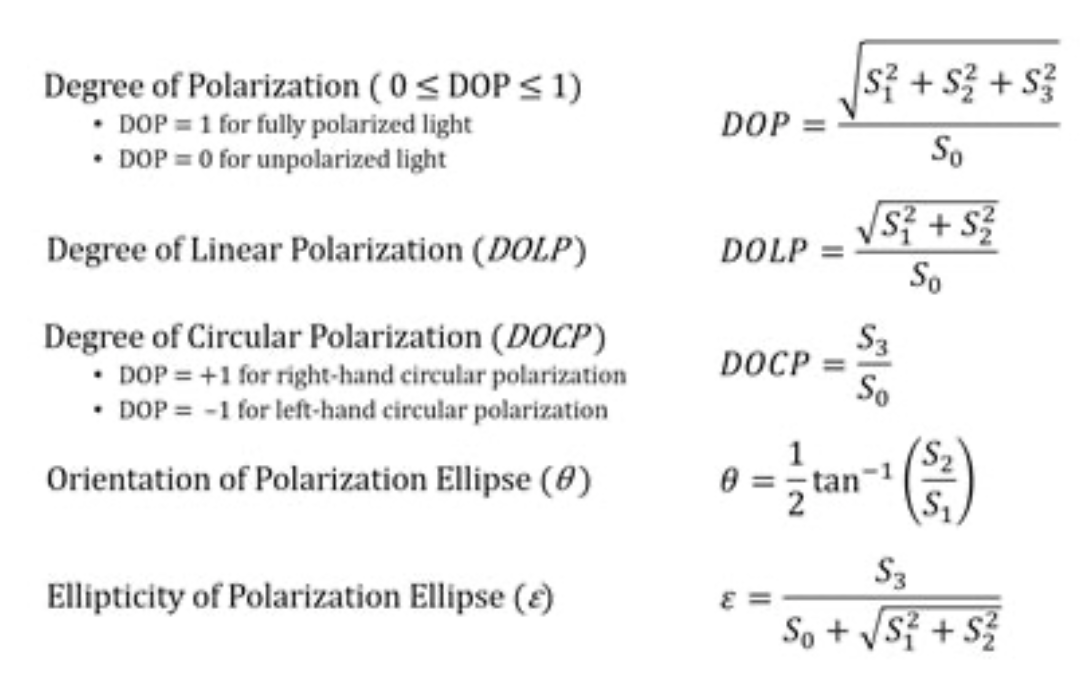

In [ ]:
import pypolar.mueller as mueller
import pypolar.visualization as vis

np.set_printoptions(suppress=True)  # print 1e-16 as zero

In [ ]:
def dolp(S):
    """Return the degree of polarization."""
    return np.sqrt(S[1] ** 2 + S[2] ** 2) / S[0]


def docp(S):
    """Return the degree of circular polarization (+1 for R, -1 for L)."""
    return S[3] / S[0]


def summarize_stokes(pol):
    print("Stokes Parameters\t\t:", pol)
    print("Degree of Polarization\t\t:", mueller.degree_of_polarization(pol))
    print("Degree of Linear Polarization\t:", dolp(pol))
    print("Degree of Circular Polarization\t:", docp(pol))
    print("Orientation of Ellipse\t\t:", np.rad2deg(mueller.ellipse_orientation(pol)))
    print(
        "Ellipticity Angle of Ellipse\t:", np.rad2deg(mueller.ellipse_ellipticity(pol))
    )


# summarize_stokes(mueller.stokes_linear(np.deg2rad(45)))
summarize_stokes(mueller.stokes_left_circular())

In [ ]:
v = mueller.stokes_left_circular()
vis.draw_stokes_animated(v)